In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
R-peak validation pipeline — clean v2
-------------------------------------
What this does:
  1) Load ECG from TDMS (returns Python datetime start, not Arrow)
  2) Read LabVIEW RR (.lvm) robustly (comma/dot decimals; sec/ms/µs)
  3) Detect ECG R-peaks (NeuroKit2)
  4) Build LabVIEW R-peak *sample indices* from RR (+ header/time-based offsets)
  5) Compute refined offset around header-derived base offset (optional 60s clip)
  6) Create binary trains (0/1), align with overlap, estimate small lag
  7) Report TP/FP/FN/Sens/PPV/F1 before/after lag
  8) (Optional) Sweep NeuroKit2 cleaning methods and export CSV

Requires: pandas, numpy, neurokit2, nptdms, arrow, scipy, matplotlib
"""

from __future__ import annotations
import re
from typing import Tuple, Dict, Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate, convolve
import neurokit2 as nk
import nptdms
import arrow
from datetime import datetime

# ============================
# I/O helpers
# ============================

def read_labview_rr(path: str, skiprows: int = 22) -> np.ndarray:
    """Read RR intervals (seconds) from LabVIEW .lvm or text file."""
    try:
        df = pd.read_csv(path, sep="\t", engine="python", skiprows=skiprows, header=0, decimal=",")
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", skiprows=skiprows, header=0)
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))

    # choose plausible RR column
    cols = [c for c in df.columns if str(c).lower() not in ("x_value", "xvalue", "comment")]
    rr = None
    if "Untitled" in df.columns:
        rr = pd.to_numeric(df["Untitled"], errors="coerce").dropna().to_numpy(float)

    if rr is None:
        for c in cols:
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy(float)
            if v.size:
                med = float(np.nanmedian(v))
                if 0.1 < med < 5.0:
                    rr = v; break
        if rr is None and cols:
            rr = pd.to_numeric(df[cols[0]], errors="coerce").dropna().to_numpy(float)

    if rr is None or rr.size == 0:
        raise ValueError("Could not find an RR column in the provided LabVIEW file.")

    # unit normalization
    med = float(np.nanmedian(rr))
    if med > 10000:   # microseconds
        rr = rr / 1_000_000.0
    elif med > 5:     # milliseconds
        rr = rr / 1_000.0
    return rr


def rr_to_peak_samples(rr_seconds: Iterable[float], fs: float, t0_s: float = 0.0) -> np.ndarray:
    """Convert RR (sec) to absolute peak sample indices (int), first peak at t0_s."""
    rr = np.asarray(rr_seconds, dtype=float).ravel()
    t_peaks = t0_s + np.cumsum(np.insert(rr, 0, 0.0))
    return np.rint(t_peaks * fs).astype(np.int64)


def make_binary_series(peak_samples: np.ndarray, n_samples: Optional[int], left_pad: int = 0, right_pad: int = 0) -> np.ndarray:
    """Create a binary series with ones at peak positions, with optional padding."""
    peaks = np.asarray(peak_samples, dtype=int)
    if n_samples is None:
        length = (int(peaks.max()) + 1 if peaks.size else 0) + left_pad + right_pad
    else:
        length = int(n_samples) + left_pad + right_pad
    x = np.zeros(length, dtype=np.uint8)
    shifted = peaks + left_pad
    valid = shifted[(shifted >= 0) & (shifted < length)]
    x[valid] = 1
    return x

# ============================
# Time parsing & TDMS helpers
# ============================

def read_header_datetime_lvm(path: str, default_date_fmt: str = "%Y/%m/%d") -> Optional[datetime]:
    """
    Parse 'Date' and 'Time' from a LabVIEW .lvm header before ***End_of_Header***.
    Returns a naive datetime (no tz) if found; otherwise None.
    """
    date_val = None
    time_val = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            ls = line.strip()
            if ls.startswith("***End_of_Header***"):
                break
            low = ls.lower()
            if low.startswith("date\t") and date_val is None:
                date_val = ls.split("\t", 1)[1].strip()
            elif "time" in low and "time_pref" not in low and low.startswith("time\t") and time_val is None:
                time_val = ls.split("\t", 1)[1].strip()

    if not time_val:
        return None

    m = re.match(r"^(\d{2}:\d{2}:\d{2})[,.](\d+)$", time_val)
    if m:
        hhmmss, frac = m.group(1), m.group(2)
        if len(frac) > 6 and int(frac[6]) >= 5:
            frac6 = str(int(frac[:6]) + 1).zfill(6)
        else:
            frac6 = frac[:6].ljust(6, "0")
        time_norm = f"{hhmmss}.{frac6}"
        t_dt = datetime.strptime(time_norm, "%H:%M:%S.%f")
    else:
        if not re.match(r"^\d{2}:\d{2}:\d{2}$", time_val):
            return None
        t_dt = datetime.strptime(time_val, "%H:%M:%S")

    if date_val:
        fmts = [default_date_fmt, "%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"]
        for fmt in fmts:
            try:
                d = datetime.strptime(date_val, fmt).date()
                return datetime.combine(d, t_dt.time())
            except ValueError:
                continue
        return t_dt
    return t_dt


def _dt_from_any(v, assume_tz: str = "UTC", out_tz: Optional[str] = "Europe/Copenhagen", naive: bool = True) -> Optional[datetime]:
    """Parse any datetime-like to Python datetime; Arrow only used internally for DST."""
    try:
        a = arrow.get(pd.to_datetime(v))
        if a.tzinfo is None:
            a = a.replace(tzinfo=assume_tz)
        if out_tz:
            a = a.to(out_tz)
        return a.naive if naive else a.datetime
    except Exception:
        return None


def _find_time_in_props_dt(props: dict,
                           assume_tz="UTC",
                           out_tz="Europe/Copenhagen",
                           naive=True) -> Optional[datetime]:
    if not isinstance(props, dict):
        return None
    keys = (
        "wf_start_time",
        "ni_expstarttimestamp",
        "ni_exptimestamp",
        "wf_start",
        "start_time",
        "time",
    )
    for k, v in props.items():
        kl = str(k).lower()
        if any(tag in kl for tag in keys) and v is not None:
            dt = _dt_from_any(v, assume_tz=assume_tz, out_tz=out_tz, naive=naive)
            if dt is not None:
                return dt
    return None


def _extract_fs_from_props(props: dict, default_fs=512.0) -> float:
    if not isinstance(props, dict):
        return float(default_fs)
    for key in ("wf_increment", "increment", "dt"):
        if key in props and props[key] not in (None, ""):
            try:
                inc = float(props[key])
                if inc > 0:
                    return 1.0 / inc
            except Exception:
                pass
    for key in ("wf_sample_rate", "sample_rate", "sampling_rate", "rate"):
        if key in props and props[key] not in (None, ""):
            try:
                return float(props[key])
            except Exception:
                pass
    return float(default_fs)


def extract_tdms_ecg_and_time(
    tdms_path: str,
    prefer_group: Optional[str] = None,
    prefer_channel: Optional[str] = None,
    assume_tz: str = "UTC",
    out_tz: str = "Europe/Copenhagen",
    naive_return: bool = True,
) -> Tuple[pd.Series, float, Optional[datetime]]:
    """Return (ECG_series, fs, start_datetime_or_None) — start time is a Python datetime."""
    tdms = nptdms.TdmsFile.read(tdms_path)
    file_props = getattr(tdms, "properties", {}) or {}
    file_dt = _find_time_in_props_dt(file_props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return)

    channels = []
    for g in tdms.groups():
        for ch in g.channels():
            try:
                data = ch[:]
            except Exception:
                data = ch.data
            if data is None:
                continue
            arr = np.asarray(data)
            if arr.dtype.kind in ("i", "u", "f"):
                channels.append((g.name, ch.name, arr, ch.properties))
    if not channels:
        raise RuntimeError("No numeric channels found in TDMS.")

    if prefer_group and prefer_channel:
        chosen = next((t for t in channels if t[0]==prefer_group and t[1]==prefer_channel), None)
        if chosen is None:
            raise RuntimeError(f"Channel {prefer_group}.{prefer_channel} not found.")
    else:
        ekg_like = [t for t in channels if "ekg" in t[1].lower() or "ecg" in t[1].lower()]
        chosen = ekg_like[0] if ekg_like else channels[0]

    gname, cname, arr, props = chosen
    fs = _extract_fs_from_props(props)
    ch_dt = _find_time_in_props_dt(props, assume_tz=assume_tz, out_tz=out_tz, naive=naive_return) or file_dt

    ecg = pd.Series(arr, name=f"{gname}.{cname}")
    return ecg, fs, ch_dt

# ============================
# Peak detection & metrics
# ============================

def detect_ecg_peaks(signal: pd.Series, fs: float, clean_method: str = "neurokit") -> np.ndarray:
    """Clean ECG and return R-peak indices (global sample indices)."""
    cleaned = nk.ecg_clean(signal.to_numpy(), sampling_rate=int(fs), method=clean_method)
    peaks_dict, _ = nk.ecg_peaks(cleaned, sampling_rate=int(fs))
    binary = peaks_dict.get("ECG_R_Peaks")
    if binary is None:
        for v in peaks_dict.values():
            try:
                binary = np.asarray(v); break
            except Exception:
                continue
    idx = np.flatnonzero(np.asarray(binary, dtype=np.uint8))
    return idx


def event_metrics_overlap_lag(gold_idx: np.ndarray,
                              test_idx: np.ndarray,
                              fs: float,
                              tol_ms: float = 40.0,
                              max_lag_ms: float = 150.0) -> Dict[str, float]:
    """Compute TP/FP/FN/Sensitivity/PPV/F1 after overlap + best small lag + tolerance window."""
    gold_idx = np.asarray(gold_idx, dtype=int)
    test_idx = np.asarray(test_idx, dtype=int)

    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    if hi <= lo:
        raise ValueError("No temporal overlap between peak sequences.")

    g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo
    t = test_idx[(test_idx >= lo) & (test_idx < hi)] - lo
    N = int(hi - lo)
    a = np.zeros(N, dtype=np.uint8); a[g] = 1
    b = np.zeros(N, dtype=np.uint8); b[t] = 1

    maxlag = int(round(max_lag_ms/1000.0*fs))
    bestlag = 0; best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    if bestlag > 0:
        b2 = b[bestlag:]; a2 = a[:len(b2)]
    elif bestlag < 0:
        a2 = a[-bestlag:]; b2 = b[:len(a2)]
    else:
        a2, b2 = a, b

    tol = int(round(tol_ms/1000.0*fs))
    win = np.ones(2*tol+1, dtype=int)
    TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
    FP = int(int(b2.sum()) - TP)
    FN = int(int(a2.sum()) - TP)
    sens = TP/(TP+FN) if (TP+FN) > 0 else np.nan
    ppv  = TP/(TP+FP) if (TP+FP) > 0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

    return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1,
                lag_samples=bestlag, tol_samples=tol, N_overlap=len(a2), lo=lo, hi=lo+len(a2))

# ============================
# Offset refinement & proof
# ============================

def _count_matches(g_idx, t_idx, fs, offset_s, tol_ms=40.0, limit_first_s=None):
    tol_s = tol_ms / 1000.0
    g = np.asarray(g_idx, int)
    t = np.asarray(t_idx, int) + int(round(offset_s * fs))
    if limit_first_s is not None:
        g = g[g/fs <= limit_first_s]
        t = t[t/fs <= limit_first_s]
    gt = g / fs
    tt = t / fs
    i = j = 0; TP = 0
    while i < len(gt) and j < len(tt):
        dt = tt[j] - gt[i]
        if abs(dt) <= tol_s:
            TP += 1; i += 1; j += 1
        elif dt < -tol_s:
            j += 1
        else:
            i += 1
    return TP


def compute_refined_offset_around_base(
    base_offset_s: float, fs: float,
    lab_idx_base: np.ndarray, nk_idx: np.ndarray,
    *, refine_half_range_s: float = 30.0,
    refine_step_ms: float = 4.0,
    refine_first_s: float = 15*60.0,
    tol_ms: float = 40.0,
) -> tuple[float, pd.DataFrame]:
    """
    Find 'delta' omkring base_offset_s, men skub **LabVIEW** (ikke NK).
    Returnerer (refined_offset_s, df_deltas), hvor refined = base + best_delta.
    +delta betyder: skub LabVIEW SENERE (til højre).
    """

    def _count_matches_lab_shift(g_idx, t_idx, fs, delta_s, tol_ms=40.0, limit_first_s=None):
        tol_s = tol_ms / 1000.0
        g = np.asarray(g_idx, int) + int(round(delta_s * fs))   # <-- skub LabVIEW
        t = np.asarray(t_idx, int)
        if limit_first_s is not None:
            g = g[g/fs <= limit_first_s]
            t = t[t/fs <= limit_first_s]
        gt = g / fs; tt = t / fs
        i = j = 0; TP = 0
        while i < len(gt) and j < len(tt):
            dt = tt[j] - gt[i]
            if abs(dt) <= tol_s:
                TP += 1; i += 1; j += 1
            elif dt < -tol_s:
                j += 1
            else:
                i += 1
        return TP

    step_s = refine_step_ms / 1000.0
    deltas = np.arange(-refine_half_range_s, refine_half_range_s + step_s, step_s)

    rows = []
    for d in deltas:
        tp = _count_matches_lab_shift(
            lab_idx_base, nk_idx, fs, d,
            tol_ms=tol_ms, limit_first_s=refine_first_s
        )
        rows.append((d, tp))
    df = pd.DataFrame(rows, columns=["delta_s", "TP"]).sort_values("delta_s").reset_index(drop=True)

    best_row = df.iloc[df["TP"].argmax()]
    best_delta = float(best_row["delta_s"])
    refined_offset_s = base_offset_s + best_delta
    return refined_offset_s, df



def prove_alignment(ecg, fs, lab_idx, nk_idx, *, tol_ms=40, best_off_s=0.0,
                    max_lag_ms=150.0, plot_window=(100, 10),lab_idx_base=None):
    """Apply given offset to NK, print lengths/ranges/overlap, find best small lag, report metrics, plot window."""
    tol_samp = int(round(tol_ms/1000.0*fs))
    maxlag = int(round(max_lag_ms/1000.0*fs))

    print("=== BEFORE OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}, range={lab_idx.max()-lab_idx.min()}")
    print(f"NeuroKit idx: n={len(nk_idx)}, min={nk_idx.min()}, max={nk_idx.max()}, range={nk_idx.max()-nk_idx.min()}")
    if len(lab_idx) != len(nk_idx):
        print(f"[INFO] Different number of peaks ({len(lab_idx)} vs {len(nk_idx)}) — expected.\n")

    nk_idx_off = nk_idx + int(round(best_off_s * fs))
    print(f"[OFFSET] Using LABVIEW refined offset baked into lab_idx (no NK shift).")

    print("\n=== AFTER OFFSET ===")
    print(f"LabVIEW idx: n={len(lab_idx)}, min={lab_idx.min()}, max={lab_idx.max()}")
    print(f"NeuroKit (offset) idx: n={len(nk_idx_off)}, min={nk_idx_off.min()}, max={nk_idx_off.max()}")
    overlap_start = max(lab_idx.min(), nk_idx_off.min())
    overlap_end   = min(lab_idx.max(), nk_idx_off.max())
    overlap_len   = overlap_end - overlap_start
    print(f"[INFO] Overlap range: {overlap_start}–{overlap_end} ({overlap_len/fs:.2f} s, {overlap_len} samples)")

    if overlap_len <= 0:
        raise ValueError("No temporal overlap after applying offset.")

    N = int(overlap_len)
    a = np.zeros(N, dtype=np.uint8); 
    b = np.zeros(N, dtype=np.uint8)
    a[lab_idx[(lab_idx>=overlap_start) & (lab_idx<overlap_end)] - overlap_start] = 1
    b[nk_idx_off[(nk_idx_off>=overlap_start) & (nk_idx_off<overlap_end)] - overlap_start] = 1
    print(f"[DEBUG] Binary lengths: lab={len(a)}, nk={len(b)}, sum(lab)={a.sum()}, sum(nk)={b.sum()}")

    bestlag, _ = 0, 0
    # small lag search
    best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    print(f"[LAG] Best small lag = {bestlag:+d} samples (~{bestlag/fs*1000:.1f} ms)")

    win = np.ones(2*tol_samp+1, dtype=int)
    def metrics_from_bins(A, B):
        TP = int((convolve(A, win, mode='same') * B > 0).sum())
        FP = int(B.sum() - TP)
        FN = int(A.sum() - TP)
        sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
        ppv  = TP/(TP+FP) if (TP+FP)>0 else np.nan
        f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan
        return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1)

    base_m = metrics_from_bins(a, b)
    if bestlag > 0:
        A2 = a[bestlag:]; B2 = b[:-bestlag]
    elif bestlag < 0:
        A2 = a[:bestlag];  B2 = b[-bestlag:]
    else:
        A2, B2 = a, b
    best_m = metrics_from_bins(A2, B2)

    print("\n[OVERLAP METRICS]")
    print(f"Before lag:  TP={base_m['TP']}, FP={base_m['FP']}, FN={base_m['FN']}, F1={base_m['F1']:.4f}")
    print(f" After lag:  TP={best_m['TP']}, FP={best_m['FP']}, FN={best_m['FN']}, F1={best_m['F1']:.4f}")

    # best_off_s = KNOWN_OFF_S + base_off_s - refined_offset_s

        # --- Plot ---
    start_s, dur_s = plot_window
    s = int(start_s*fs); e = int((start_s+dur_s)*fs)

    # Windowed indices
    lab_loc = lab_idx[(lab_idx>=s) & (lab_idx<e)] - s          # refined
    nk_loc  = nk_idx[(nk_idx>=s) & (nk_idx<e)] - s

    plt.figure(figsize=(12,4))
    t = np.arange(s,e)/fs
    plt.plot(t, ecg.values[s:e], label="ECG")  # line stays blue

    # LabVIEW (refined): GREEN TRIANGLES (distinct from blue ECG)
    if len(lab_loc):
        plt.scatter(t[lab_loc], ecg.values[s:e][lab_loc],
                    s=30, marker='^', color='tab:green', edgecolors='k',
                    linewidths=0.5, zorder=3, label="LabVIEW peaks (refined)")

    # NK peaks: ORANGE DOTS
    if len(nk_loc):
        plt.scatter(t[nk_loc], ecg.values[s:e][nk_loc],
                    s=24, color='tab:orange', edgecolors='k',
                    linewidths=0.5, zorder=3, label="NK peaks")

    # Optional: show LabVIEW base (if provided by caller)
    if 'lab_idx_base' in locals() and lab_idx_base is not None:
        lab_base_loc = lab_idx_base[(lab_idx_base>=s) & (lab_idx_base<e)] - s
        if len(lab_base_loc):
            plt.scatter(t[lab_base_loc], ecg.values[s:e][lab_base_loc],
                        s=24, marker='x', color='tab:green', linewidths=1.0,
                        zorder=3, label="LabVIEW peaks (base)")

    plt.title(f"Visual check (window {start_s}-{start_s+dur_s}s); lag best = {bestlag} samp")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()



    return {
        "applied_offset_s": float(best_off_s),
        "best_lag_samples": int(bestlag),
        "before_overlap_metrics": base_m,
        "after_overlap_metrics": best_m,
    }

def plot_comparison_window(ecg, fs, nk_idx, lab_idx_refined, lab_idx_base=None,
                           start_s=100.0, dur_s=8.0, clean_method="neurokit"):
    """
    Plot a short window comparing:
      - raw ECG (line)
      - cleaned ECG (line)
      - NK peaks (orange dots)
      - LabVIEW peaks (refined) as green triangles
      - LabVIEW peaks (base) as green X (optional)
    """
    # Clean ECG for visualization (same method you used in detection)
    cleaned = nk.ecg_clean(ecg.to_numpy(), sampling_rate=int(fs), method=clean_method)

    s = int(start_s*fs); e = int((start_s+dur_s)*fs)
    t = np.arange(s, e)/fs

    nk_loc   = nk_idx[(nk_idx>=s) & (nk_idx<e)] - s
    lab_loc  = lab_idx_refined[(lab_idx_refined>=s) & (lab_idx_refined<e)] - s
    base_loc = None
    if lab_idx_base is not None:
        base_loc = lab_idx_base[(lab_idx_base>=s) & (lab_idx_base<e)] - s

    plt.figure(figsize=(12,4))
    # Raw & cleaned lines
    plt.plot(t, ecg.values[s:e],               label="ECG (raw)",     alpha=0.8)
    plt.plot(t, cleaned[s:e],                  label=f"ECG (cleaned: {clean_method})", alpha=0.9)

    # Peaks
    if nk_loc.size:
        plt.scatter(t[nk_loc], cleaned[s:e][nk_loc],
                    s=28, color='tab:orange', edgecolors='k',
                    linewidths=0.5, zorder=3, label="NK peaks")

    if lab_loc.size:
        plt.scatter(t[lab_loc], cleaned[s:e][lab_loc],
                    s=34, marker='^', color='tab:green', edgecolors='k',
                    linewidths=0.5, zorder=3, label="LabVIEW peaks (refined)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], cleaned[s:e][base_loc],
                    s=30, marker='x', color='tab:green', linewidths=1.0,
                    zorder=3, label="LabVIEW peaks (base)")

    plt.title(f"Comparison window {start_s:.1f}–{start_s+dur_s:.1f}s")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# ============================
# Optional: NK method sweep
# ============================

def evaluate_nk_variants(ecg_series, fs, lab_idx, tol_ms=40.0, max_lag_ms=150.0,
                         clean_methods=None, verbose=True):
    if clean_methods is None:
        clean_methods = ["neurokit", "biosppy", "pantompkins1985", "hamilton", "elgendi", "engzeemod2012"]

    rows = []
    for cm in clean_methods:
        try:
            nk_idx = detect_ecg_peaks(ecg_series, fs, clean_method=cm)
            m = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=tol_ms, max_lag_ms=max_lag_ms)
            rows.append({"clean_method": cm, **m})
            if verbose:
                print(f"[EVAL] {cm} -> F1={m['F1']:.4f}, Sens={m['Sensitivity']:.4f}, PPV={m['PPV']:.4f}")
        except Exception as e:
            rows.append({"clean_method": cm, "error": str(e)})
            if verbose:
                print(f"[EVAL] {cm} -> ERROR: {e}")
    df = pd.DataFrame(rows)
    if "F1" in df.columns:
        df = df.sort_values(by=["F1"], ascending=False, na_position="last").reset_index(drop=True)
    return df

# ============================
# Main
# ============================

def main(
    TDMS_PATH: str,
    LABVIEW_LVM_PATH: str,
    *,
    FS_FALLBACK: float = 512.0,
    LOCAL_TZ: str = "Europe/Copenhagen",
    KNOWN_LAB_INITIAL_SKIP_S: Optional[float] = None,
    TOL_MS: float = 40.0,
    MAX_LAG_MS: float = 150.0,
    PLOT_START_S: float = 100.0,
    PLOT_DUR_S: float = 20.0,
    REFINE_HALF_RANGE_S: float = 30.0,
    REFINE_STEP_MS: float = 4.0,
    REFINE_FIRST_S: float = 15*60.0,
    BASE_SUBTRACT_S: float = 0.0,   # e.g. 60.0 if LabVIEW clipped first 60s
    RUN_SWEEP: bool = False,
    SWEEP_CSV_OUT: Optional[str] = None,
    return_objects: bool = False
):
    # 1) Load ECG + start time
    ecg, fs, tdms_start_dt = extract_tdms_ecg_and_time(
        TDMS_PATH,
        assume_tz="UTC",
        out_tz=LOCAL_TZ,
        naive_return=True
    )
    if fs is None:
        fs = FS_FALLBACK
    fs = float(fs)
    print(f"[TDMS] Start (local naive): {tdms_start_dt}, fs={fs} Hz")

    # 2) NK peaks
    nk_idx = detect_ecg_peaks(ecg, fs=fs)
    print(f"[NK] Detected {len(nk_idx)} peaks.")

    # 3) LabVIEW RR -> peaks + header time
    rr = read_labview_rr(LABVIEW_LVM_PATH)
    lab_header_dt = read_header_datetime_lvm(LABVIEW_LVM_PATH)
    if lab_header_dt is None:
        print("[WARN] No LabVIEW header time found — offset refinement will center at 0.")
        lab_header_dt = tdms_start_dt  # neutralize

    # Base offset from headers (+ optional known clip)
    base_offset_s = (lab_header_dt - tdms_start_dt).total_seconds()
    if KNOWN_LAB_INITIAL_SKIP_S:
        base_offset_s -= float(KNOWN_LAB_INITIAL_SKIP_S)
    print(f"[BASE] Header-derived base offset ≈ {base_offset_s:+.3f} s")

    # Build LabVIEW peaks *temporarily* with header base (for quick plots if needed)
    lab_idx_base = rr_to_peak_samples(rr, fs=fs, t0_s=base_offset_s)
    print(f"[LAB] Built {len(lab_idx_base)} LabVIEW peaks (using base offset).")

    # 4) Refine offset around base
    refined_off_s, df_offsets = compute_refined_offset_around_base(
        base_offset_s=base_offset_s,
        fs=fs,
        lab_idx_base=lab_idx_base,
        nk_idx=nk_idx,
        refine_half_range_s=REFINE_HALF_RANGE_S,
        refine_step_ms=REFINE_STEP_MS,
        refine_first_s=REFINE_FIRST_S,
        tol_ms=TOL_MS
    )
    print(f"[REFINE] base={base_offset_s:+.3f}s  +  delta={(refined_off_s-base_offset_s):+.3f}s  =>  refined={refined_off_s:+.3f}s")

    print(f"[REFINE] Best offset around base = {refined_off_s:+.3f} s")

    # Final LabVIEW peaks with refined offset (apply delta relative to base):
    lab_idx = rr_to_peak_samples(rr, fs=fs, t0_s=refined_off_s)

    print(f"[LAB] Rebuilt LabVIEW peaks with refined offset, n={len(lab_idx)}")

    # 5) Metrics with lag & tol
    metrics = event_metrics_overlap_lag(lab_idx, nk_idx, fs=fs, tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS)
    print("[METRICS]", metrics)

    # 6) Proof and plot
    proof = prove_alignment(
        ecg=ecg, fs=fs,
        lab_idx=lab_idx, nk_idx=nk_idx,
        tol_ms=TOL_MS, best_off_s=0.0,
        max_lag_ms=MAX_LAG_MS,
        plot_window=(PLOT_START_S, PLOT_DUR_S),
        lab_idx_base=lab_idx_base   # <- så du kan se "base" vs "refined"
    )

    print("[PROOF]", proof)

    # 7) Optional NK method sweep
    if RUN_SWEEP:
        res = evaluate_nk_variants(ecg, fs, lab_idx, tol_ms=TOL_MS, max_lag_ms=MAX_LAG_MS, verbose=True)
        if SWEEP_CSV_OUT:
            try:
                pd.DataFrame(res).to_csv(SWEEP_CSV_OUT, index=False)
                print(f"[SWEEP] Saved to: {SWEEP_CSV_OUT}")
            except Exception as e:
                print(f"[SWEEP] Could not save CSV: {e}")

    if return_objects:
        return dict(
            ecg=ecg, fs=fs, nk_idx=nk_idx, lab_idx=lab_idx,
            TOL_MS=TOL_MS, MAX_LAG_MS=MAX_LAG_MS,
            tdms_start_dt=tdms_start_dt, lab_header_dt=lab_header_dt,
            base_offset_s=base_offset_s, refined_offset_s=refined_off_s,
            offsets_df=df_offsets, metrics=metrics, proof=proof
        )


Edit TDMS_PATH and LABVIEW_LVM_PATH, then run main(...).
[TDMS] Start (local naive): 2016-10-12 11:05:02, fs=512.0 Hz
[NK] Detected 167188 peaks.
[BASE] Header-derived base offset ≈ +17.182 s
[LAB] Built 186085 LabVIEW peaks (using base offset).
[REFINE] base=+17.182s  +  delta=-23.580s  =>  refined=-6.398s
[REFINE] Best offset around base = -6.398 s
[LAB] Rebuilt LabVIEW peaks with refined offset, n=186085
[METRICS] {'TP': 15285, 'FP': 151815, 'FN': 170759, 'Sensitivity': 0.08215798413278579, 'PPV': 0.0914721723518851, 'F1': 0.08656525383412997, 'lag_samples': 75, 'tol_samples': 20, 'N_overlap': 82266434, 'lo': np.int64(949), 'hi': np.int64(82267383)}
=== BEFORE OFFSET ===
LabVIEW idx: n=186085, min=-3276, max=82267458, range=82270734
NeuroKit idx: n=167188, min=949, max=82458253, range=82457304
[INFO] Different number of peaks (186085 vs 167188) — expected.

[OFFSET] Using LABVIEW refined offset baked into lab_idx (no NK shift).

=== AFTER OFFSET ===
LabVIEW idx: n=186085, min=-3276,

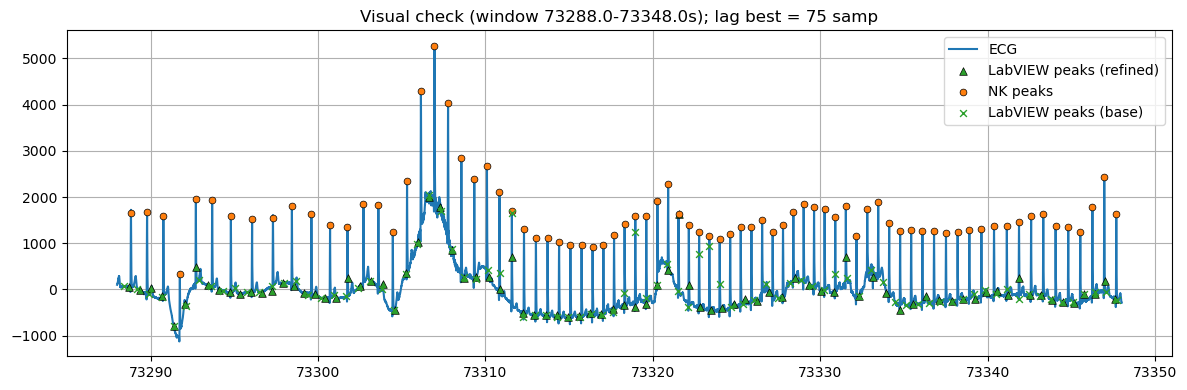

[PROOF] {'applied_offset_s': 0.0, 'best_lag_samples': 75, 'before_overlap_metrics': {'TP': 15335, 'FP': 151766, 'FN': 170709, 'Sensitivity': 0.08242673776095977, 'PPV': 0.09177084517746752, 'F1': 0.08684817851024365}, 'after_overlap_metrics': {'TP': 15742, 'FP': 151359, 'FN': 170302, 'Sensitivity': 0.08461439229429597, 'PPV': 0.09420649786655974, 'F1': 0.08915318070480963}}


In [14]:
TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
LABVIEW_LVM_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"
print("Edit TDMS_PATH and LABVIEW_LVM_PATH, then run main(...).")
# Example:
out = main(TDMS_PATH, LABVIEW_LVM_PATH, KNOWN_LAB_INITIAL_SKIP_S=60.0,
           PLOT_START_S=73288.0, PLOT_DUR_S=60.0, RUN_SWEEP=False, return_objects=True)


In [16]:
# From your 'out' dict
ecg         = out["ecg"]
fs          = out["fs"]
nk_idx      = out["nk_idx"]
lab_idx     = out["lab_idx"]         # refined (final)
lab_idx_base= rr_to_peak_samples(read_labview_rr(LABVIEW_LVM_PATH), fs, t0_s=out["base_offset_s"])

# A) Existing proof plot (now with nicer markers and optional base)
# proof = prove_alignment(
#     ecg=ecg, fs=fs,
#     lab_idx=lab_idx, nk_idx=nk_idx,
#     tol_ms=out["TOL_MS"] if "TOL_MS" in out else 40,
#     best_off_s=0.0,
#     max_lag_ms=out["MAX_LAG_MS"] if "MAX_LAG_MS" in out else 150,
#     plot_window=(73288.0, 60.0),
#     lab_idx_base=lab_idx_base
# )


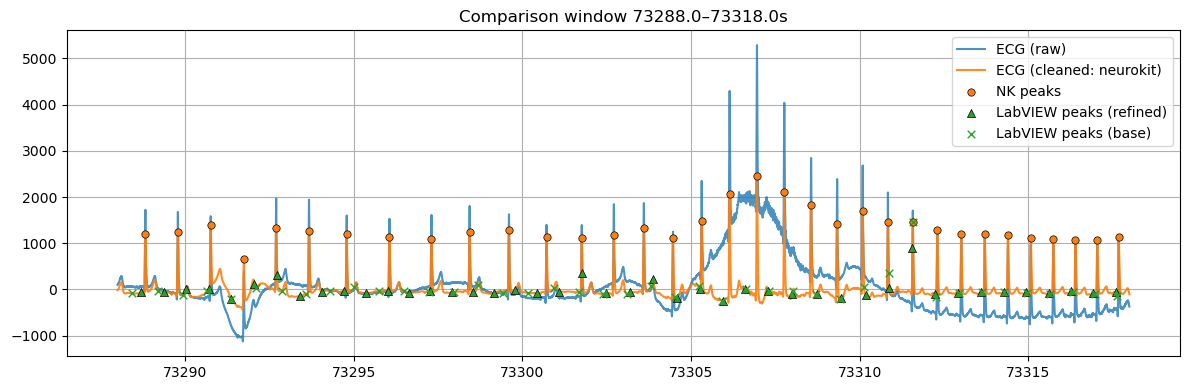

In [18]:

# B) Extra comparison plot (short window)
plot_comparison_window(
    ecg, fs, nk_idx, lab_idx_refined=lab_idx, lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=30.0, clean_method="neurokit"
)


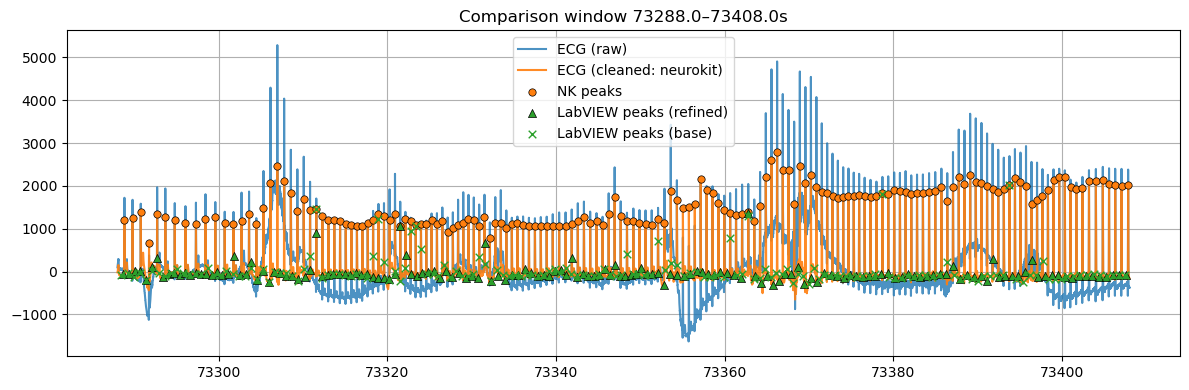

In [19]:
plot_comparison_window(
    ecg, fs, nk_idx, lab_idx_refined=lab_idx, lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=120.0, clean_method="neurokit"
)

<Axes: xlabel='offset_s'>

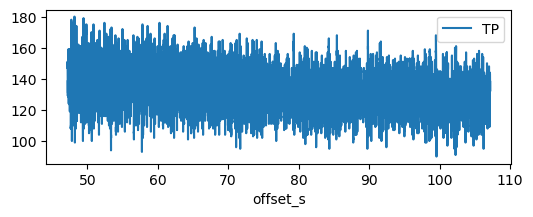

In [ ]:
df = out["offsets_df"]
df.plot(x="offset_s", y="TP", figsize=(6,2))


In [25]:
def plot_raw_clean_with_peaks(
    ecg, fs,
    nk_idx,
    lab_idx_refined,
    lab_idx_base=None,
    start_s=100.0, dur_s=6.0,
    clean_method="neurokit",
    show_stems=False
):
    """
    Plotter kort vindue med:
      - ECG (raw, cleaned)
      - NK peaks (raw & cleaned)
      - LabVIEW peaks (raw & cleaned)
      - LabVIEW base (valgfri)
      - Alle farver og symboler unikke
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import neurokit2 as nk

    cleaned = nk.ecg_clean(ecg.to_numpy(), sampling_rate=int(fs), method=clean_method)

    s = int(start_s * fs); e = int((start_s + dur_s) * fs)
    t = np.arange(s, e) / fs
    raw_win = ecg.values[s:e]
    cln_win = cleaned[s:e]

    nk_loc   = nk_idx[(nk_idx >= s) & (nk_idx < e)] - s
    lab_loc  = lab_idx_refined[(lab_idx_refined >= s) & (lab_idx_refined < e)] - s
    base_loc = None
    if lab_idx_base is not None:
        base_loc = lab_idx_base[(lab_idx_base >= s) & (lab_idx_base < e)] - s

    plt.figure(figsize=(12, 5))

    # === Signaler ===
    plt.plot(t, raw_win, color="dimgray", alpha=0.75, label="ECG (raw)")
    plt.plot(t, cln_win, color="tab:blue", alpha=0.9, label=f"ECG (cleaned: {clean_method})")

    # Lodrette streger
    if show_stems:
        y0, y1 = np.percentile(raw_win, [5, 95])
        if nk_loc.size: plt.vlines(t[nk_loc], y0, y1, color="orange", alpha=0.1)
        if lab_loc.size: plt.vlines(t[lab_loc], y0, y1, color="green", alpha=0.1)

    # === Peaks på RAW ===
    if nk_loc.size:
        plt.scatter(t[nk_loc], raw_win[nk_loc],
                    s=28, color="tab:orange", edgecolors="k", linewidths=0.4,
                    zorder=3, label="NK peaks (raw)")

    if lab_loc.size:
        plt.scatter(t[lab_loc], raw_win[lab_loc],
                    s=34, marker="^", color="limegreen", edgecolors="k",
                    linewidths=0.4, zorder=3, label="LabVIEW refined (raw)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], raw_win[base_loc],
                    s=34, marker="x", color="mediumorchid", linewidths=1.0,
                    zorder=3, label="LabVIEW base (raw)")

    # === Peaks på CLEANED ===
    if nk_loc.size:
        plt.scatter(t[nk_loc], cln_win[nk_loc],
                    s=26, color="red", edgecolors="k", linewidths=0.4,
                    zorder=4, label="NK peaks (cleaned)")

    if lab_loc.size:
        plt.scatter(t[lab_loc], cln_win[lab_loc],
                    s=34, marker="^", color="forestgreen", edgecolors="k",
                    linewidths=0.4, zorder=4, label="LabVIEW refined (cleaned)")

    if base_loc is not None and base_loc.size:
        plt.scatter(t[base_loc], cln_win[base_loc],
                    s=34, marker="x", color="deeppink", linewidths=1.0,
                    zorder=4, label="LabVIEW base (cleaned)")

    plt.title(f"Raw vs. Cleaned ECG with peaks — window {start_s:.1f}–{start_s+dur_s:.1f}s")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [µV]")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


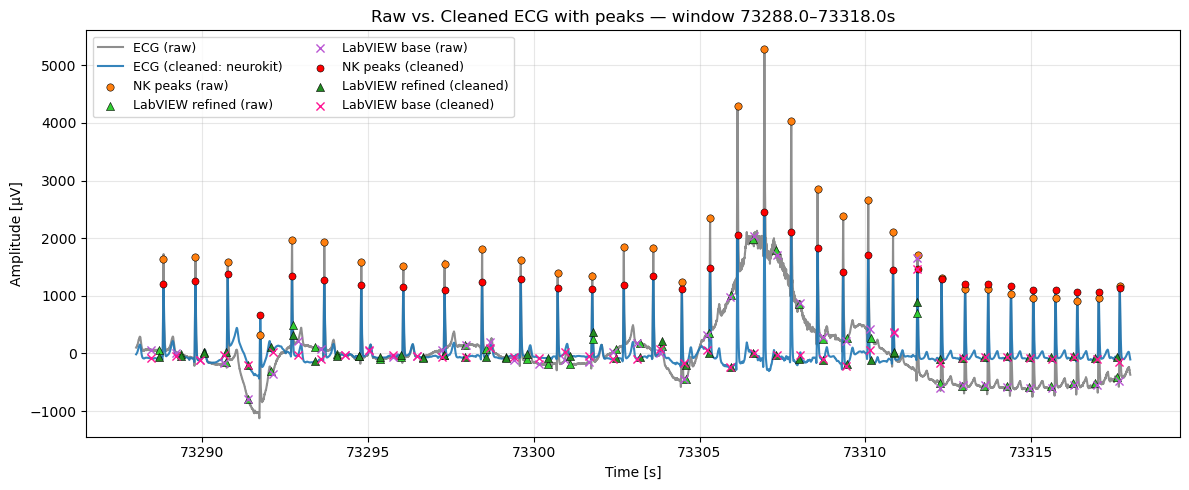

In [27]:
# typisk efter du har 'out = main(..., return_objects=True)'
ecg          = out["ecg"]
fs           = out["fs"]
nk_idx       = out["nk_idx"]
lab_idx      = out["lab_idx"]  # refined
# base-serien (valgfri)
lab_idx_base = rr_to_peak_samples(read_labview_rr(LABVIEW_LVM_PATH), fs, t0_s=out["base_offset_s"])

plot_raw_clean_with_peaks(
    ecg, fs,
    nk_idx,
    lab_idx_refined=lab_idx,
    lab_idx_base=lab_idx_base,
    start_s=73288.0, dur_s=30.0,
    clean_method="neurokit",
    show_stems=False
)
